<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%ED%8F%AC%EB%94%94%EB%B8%94%EB%A1%9D_%EA%B5%AC%EC%A1%B0_%EC%B6%94%EC%B6%9C_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

포디블록 구조 추출 AI 경진대회

https://dacon.io/competitions/official/236046/overview/description

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/데이콘/open.zip'

In [3]:
train = pd.read_csv('/content/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32994 entries, 0 to 32993
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        32994 non-null  object
 1   img_path  32994 non-null  object
 2   A         32994 non-null  int64 
 3   B         32994 non-null  int64 
 4   C         32994 non-null  int64 
 5   D         32994 non-null  int64 
 6   E         32994 non-null  int64 
 7   F         32994 non-null  int64 
 8   G         32994 non-null  int64 
 9   H         32994 non-null  int64 
 10  I         32994 non-null  int64 
 11  J         32994 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 3.0+ MB


In [4]:
train_path = sorted(glob.glob('/content/train/*.jpg'))
train['img_path'] = train_path

In [16]:
train.head()

,id,img_path,A,B,C,D,E,F,G,H,I,J
0,TRAIN_00000,/content/train/TRAIN_00000.jpg,1,0,0,0,0,0,0,0,0,0
1,TRAIN_00001,/content/train/TRAIN_00001.jpg,1,0,0,0,0,0,0,0,0,0
2,TRAIN_00002,/content/train/TRAIN_00002.jpg,1,0,0,0,0,0,0,0,0,0
3,TRAIN_00003,/content/train/TRAIN_00003.jpg,1,0,0,0,0,0,0,0,0,0
4,TRAIN_00004,/content/train/TRAIN_00004.jpg,1,0,0,0,0,0,0,0,0,0


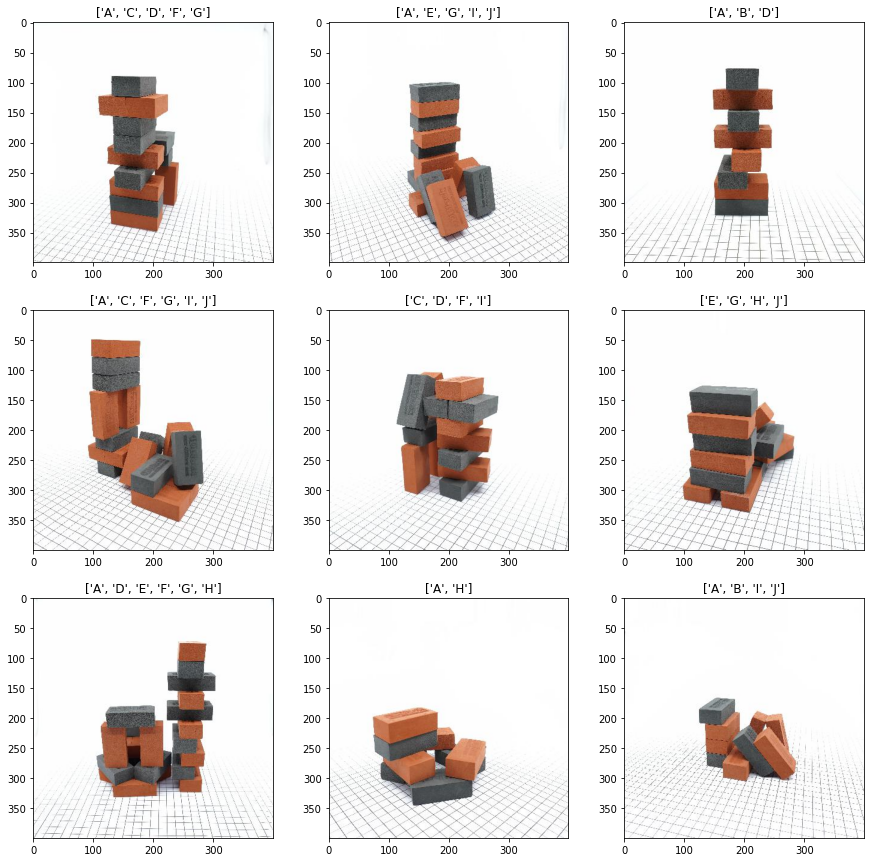

In [32]:
se_img = np.arange(len(train['img_path']))
np.random.shuffle(se_img)
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = cv2.imread(train.loc[se_img[i]]['img_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    tt = []
    for j in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']:
        if train.loc[se_img[i]][j]:
            tt.append(j)
    plt.title(tt)
plt.show()

In [5]:
class data_generater(tf.keras.utils.Sequence):
    def __init__(self, path, label=None, img_size=(400,400), batch_size=32, shuffle=False, argument=None):
        self.path = path
        self.label = label
        self.img_size = img_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.argument = argument

        self.one_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.path) / self.batch_size))

    def __getitem__(self, index):
        path_sel = self.path[self.data_idx[index * self.batch_size : (index + 1) * self.batch_size]]
        if self.label is not None:
            label_sel = self.label[self.data_idx[index * self.batch_size : (index + 1) * self.batch_size]]

        images = np.zeros((len(path_sel), img_size[0], img_size[1], 3), dtype=np.float32)

        for i, path in enumerate(path_sel):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            if self.argument is not None:
                img = self.argument(imgae=img)['img']
            img = img / 255
            images[i] = img

        if self.label is not None:
            return images, label_sel
        else :
            return images

    def one_epoch_end(self):
        self.data_idx = np.arange(len(self.path))
        if self.shuffle:
            np.random.shuffle(self.data_idx)

In [6]:
train_df, val_df = train_test_split(train, test_size=0.1 ,shuffle=True, random_state=42)
print(train_df.shape, val_df.shape)
img_size = (400,400)
train_ds = data_generater(train_df['img_path'].values, train_df.iloc[:,2:].values, shuffle=True)
val_ds = data_generater(val_df['img_path'].values, val_df.iloc[:,2:].values, shuffle=True)

(29694, 12) (3300, 12)


In [7]:
img_size = (400,400)
def make_model():
    inputs = layers.Input(shape=(img_size[0], img_size[1], 3))
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(256, 3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outouts = layers.Dense(10, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outouts)
    return model

In [8]:
model = make_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 400, 400, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 198, 198, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 198, 198, 64)     256   

In [12]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [13]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, validation_data = val_ds, epochs=10)

Epoch 1/10
928/928 [==============================] - 245s 263ms/step - loss: 7393204.0000 - accuracy: 0.1600 - val_loss: 4433123.0000 - val_accuracy: 0.4494
Epoch 2/10
928/928 [==============================] - 243s 262ms/step - loss: 3332842.0000 - accuracy: 0.2170 - val_loss: 2998824.2500 - val_accuracy: 0.4494
Epoch 3/10
928/928 [==============================] - 243s 262ms/step - loss: 1694127.1250 - accuracy: 0.2895 - val_loss: 1164197.0000 - val_accuracy: 0.4494
Epoch 4/10
928/928 [==============================] - 244s 262ms/step - loss: 728900.6250 - accuracy: 0.3330 - val_loss: 396161.1562 - val_accuracy: 0.4494
Epoch 5/10
928/928 [==============================] - 244s 263ms/step - loss: 157592.3750 - accuracy: 0.2479 - val_loss: 13.3366 - val_accuracy: 0.4494
Epoch 6/10
928/928 [==============================] - 244s 262ms/step - loss: 1.0876 - accuracy: 0.0995 - val_loss: 6.1735 - val_accuracy: 0.0367
Epoch 7/10
928/928 [==============================] - 244s 263ms/step - 